actor无通信决策,但是公用一个critic.

这意味着训练时有通信,测试时无通信

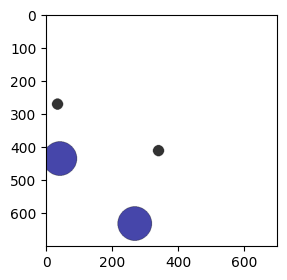

In [1]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        from pettingzoo.mpe import simple_spread_v3
        self.N = 2
        env = simple_spread_v3.env(N=self.N,
                                   local_ratio=0.5,
                                   max_cycles=1e8,
                                   render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        self.env.reset()
        self.step_n = 0

        import numpy as np
        mark0, mark1 = self.env.env.env.world.landmarks
        dist = np.array(mark0.state.p_pos) - np.array(mark1.state.p_pos)
        dist = (dist**2).sum()**0.5
        if dist < 1:
            return self.reset()

        return self.state()

    def state(self):
        state = []
        for i in self.env.agents:
            state.append(env.observe(i).tolist())
        return state

    def step(self, action):
        reward_sum = [0] * self.N
        for i in range(5):
            if i != 0:
                action = [-1, -1]
            next_reward, reward, over = self._step(action)
            for j in range(self.N):
                reward_sum[j] += reward[j]
            self.step_n -= 1

        self.step_n += 1

        return next_reward, reward_sum, over

    def _step(self, action):
        for i, _ in enumerate(env.agent_iter(self.N)):
            self.env.step(action[i] + 1)

        reward = [self.env.rewards[i] for i in self.env.agents]

        _, _, termination, truncation, _ = env.last()
        over = termination or truncation

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 50:
            over = True

        return self.state(), reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()
env.reset()

env.show()

In [2]:
import torch


class A2C:

    def __init__(self, model_actor, model_critic, model_critic_delay,
                 optimizer_actor, optimizer_critic):
        self.model_actor = model_actor
        self.model_critic = model_critic
        self.model_critic_delay = model_critic_delay
        self.optimizer_actor = optimizer_actor
        self.optimizer_critic = optimizer_critic

        self.model_critic_delay.load_state_dict(self.model_critic.state_dict())
        self.requires_grad(self.model_critic_delay, False)

    def soft_update(self, _from, _to):
        for _from, _to in zip(_from.parameters(), _to.parameters()):
            value = _to.data * 0.99 + _from.data * 0.01
            _to.data.copy_(value)

    def requires_grad(self, model, value):
        for param in model.parameters():
            param.requires_grad_(value)

    def train_critic(self, state, reward, next_state, over):
        self.requires_grad(self.model_critic, True)
        self.requires_grad(self.model_actor, False)

        #计算values和targets
        value = self.model_critic(state)

        with torch.no_grad():
            target = self.model_critic_delay(next_state)
        target = target * 0.99 * (1 - over) + reward

        #时序差分误差,也就是tdloss
        loss = torch.nn.functional.mse_loss(value, target)

        loss.backward()
        self.optimizer_critic.step()
        self.optimizer_critic.zero_grad()
        self.soft_update(self.model_critic, self.model_critic_delay)

        #减去value相当于去基线
        return (target - value).detach()

    def train_actor(self, state, action, value):
        self.requires_grad(self.model_critic, False)
        self.requires_grad(self.model_actor, True)

        #重新计算动作的概率
        prob = self.model_actor(state)
        prob = prob.gather(dim=1, index=action)

        #根据策略梯度算法的导函数实现
        #函数中的Q(state,action),这里使用critic模型估算
        prob = (prob + 1e-8).log() * value
        loss = -prob.mean()

        loss.backward()
        self.optimizer_actor.step()
        self.optimizer_actor.zero_grad()

        return loss.item()


model_actor = [
    torch.nn.Sequential(
        torch.nn.Linear(6 * env.N, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 4),
        torch.nn.Softmax(dim=1),
    ) for _ in range(env.N)
]

model_critic, model_critic_delay = [
    torch.nn.Sequential(
        torch.nn.Linear(6 * env.N * env.N, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 1),
    ) for _ in range(2)
]

optimizer_actor = [
    torch.optim.Adam(model_actor[i].parameters(), lr=1e-3)
    for i in range(env.N)
]
optimizer_critic = torch.optim.Adam(model_critic.parameters(), lr=5e-3)

a2c = [
    A2C(model_actor[i], model_critic, model_critic_delay, optimizer_actor[i],
        optimizer_critic) for i in range(env.N)
]

model_actor = None
model_critic = None
model_critic_delay = None
optimizer_actor = None
optimizer_critic = None

a2c

[<__main__.A2C at 0x7f9cb02918e0>, <__main__.A2C at 0x7f9c3da39940>]

In [3]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    state = []
    action = []
    reward = []
    next_state = []
    over = []

    s = env.reset()
    o = False
    while not o:
        a = []
        for i in range(env.N):
            #计算动作
            prob = a2c[i].model_actor(torch.FloatTensor(s[i]).reshape(
                1, -1))[0].tolist()
            a.append(random.choices(range(4), weights=prob, k=1)[0])

        #执行动作
        ns, r, o = env.step(a)

        state.append(s)
        action.append(a)
        reward.append(r)
        next_state.append(ns)
        over.append(o)

        s = ns

        if show:
            display.clear_output(wait=True)
            env.show()

    state = torch.FloatTensor(state)
    action = torch.LongTensor(action).unsqueeze(-1)
    reward = torch.FloatTensor(reward).unsqueeze(-1)
    next_state = torch.FloatTensor(next_state)
    over = torch.LongTensor(over).reshape(-1, 1)

    return state, action, reward, next_state, over, reward.sum().item()


state, action, reward, next_state, over, reward_sum = play()

reward_sum

-435.03021240234375

In [4]:
def train():
    #训练N局
    for epoch in range(5_0000):
        state, action, reward, next_state, over, _ = play()

        #合并部分字段
        state_c = state.flatten(start_dim=1)
        reward_c = reward.sum(dim=1)
        next_state_c = next_state.flatten(start_dim=1)

        for i in range(env.N):
            value = a2c[i].train_critic(state_c, reward_c, next_state_c, over)
            loss = a2c[i].train_actor(state[:, i], action[:, i], value)

        if epoch % 2500 == 0:
            test_result = sum([play()[-1] for _ in range(20)]) / 20
            print(epoch, loss, test_result)


train()

0 -11.440613746643066 -487.2028579711914
2500 -1.119187593460083 -271.2435604095459
5000 6.826124668121338 -253.62119140625
7500 0.8457289934158325 -203.59983520507814
10000 -1.034010648727417 -185.20421142578124
12500 -3.779625177383423 -122.73852005004883
15000 0.11820918321609497 -90.8776159286499
17500 0.06188208609819412 -96.55424728393555
20000 1.145486831665039 -98.22404899597169
22500 -0.15374360978603363 -91.68431587219239
25000 -0.2972413897514343 -83.5183292388916
27500 -0.002570606069639325 -97.23491764068604
30000 -0.031296394765377045 -110.00625648498536
32500 -0.007811045274138451 -87.30725765228271
35000 0.32335254549980164 -67.55157518386841
37500 -0.10166460275650024 -104.05087776184082
40000 -0.0728297010064125 -82.80452728271484
42500 -0.23787322640419006 -84.73376636505127
45000 -0.6099832653999329 -92.28320369720458
47500 -0.054144881665706635 -84.60027885437012


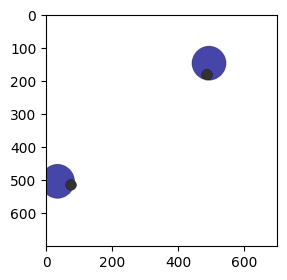

-86.06948852539062

In [5]:
play(True)[-1]